In [24]:
from prj_dataprep import load_data, feature_engineering, prepare_data
from prj_model import GMM_regime_detection, KMeans_regime_detection, AgglomerativeClustering_regime_detection, LSTMAutoencoder_GMM_regime_detection
from prj_model import visualize_clustered_regimes

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import warnings

In [7]:
print('\n1. Download stock trading data from Yahoo Finance')
startdate = '1999-02-09' # 200 trading days before the first trading day of year 2000. This is to support calculation of some trading indicators that requires 200 historical trading days.
enddate = '2025-04-18'
price_df = load_data(startdate, enddate)

price_df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1. Download stock trading data from Yahoo Finance


,SET_Close,SET_High,SET_Low,SET_Open,SET_Volume,DXY,DJI,HSI
Date,,,,,,,,
1999-02-09,320.359985,330.320007,316.820007,330.320007,233100.0,96.279999,9133.030273,9244.490234
1999-02-10,314.739990,321.709991,313.779999,316.109985,211900.0,95.959999,9177.309570,9076.330078
1999-02-11,313.649994,319.559998,308.739990,318.070007,162700.0,96.680000,9363.459961,9146.799805
1999-02-12,347.429993,347.670013,317.010010,317.630005,424100.0,96.309998,9274.889648,9425.419922
1999-02-15,344.959991,346.450012,338.200012,345.339996,266400.0,96.699997,9274.889648,9402.389648


In [8]:
print('\n2. Feature Engineering')
price_df = feature_engineering(price_df)

price_df.head()


2. Feature Engineering


,SET_Close,SET_Volume,SET_LogReturn,DXY_LogReturn,DJI_LogReturn,HSI_LogReturn,Returns,Return_1m,Vol_1m,Rolling_return_6M,...,EMA100,EMA200,EMA_ratio,EMA_cross,MA_Slope,MACD,MACD_signal,RSI,Drawdown,ROC
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,498.459991,513900.0,0.012146,-0.002052,-0.002580,0.007516,0.034321,0.180849,0.014809,-0.044675,...,428.790991,418.353462,1.148093,True,11.07335,17.965534,13.515757,84.775973,-0.086919,0.134488
2000-01-05,465.850006,511600.0,0.001407,-0.001493,-0.003562,-0.003829,-0.065421,0.101118,0.021832,-0.126526,...,429.524832,418.826064,1.069921,True,11.23965,16.683124,14.149230,59.054506,-0.146654,0.033660
2000-01-06,443.459991,408500.0,-0.005384,-0.001311,-0.001924,-0.014446,-0.048063,0.056687,0.024585,-0.168227,...,429.800776,419.071178,1.017759,True,11.23250,13.702168,14.059818,48.233651,-0.187668,-0.003304
2000-01-07,453.309998,363100.0,-0.003987,-0.000974,0.001659,-0.012442,0.022212,0.093842,0.024662,-0.139535,...,430.266305,419.411862,1.038721,True,11.26895,11.996267,13.647108,52.368587,-0.169625,-0.011169
2000-01-10,459.470001,405900.0,-0.002280,-0.001343,0.001203,-0.009518,0.013589,0.110153,0.024699,-0.109744,...,430.844596,419.810451,1.050659,True,11.43270,11.014421,13.120570,54.800160,-0.158341,-0.003708


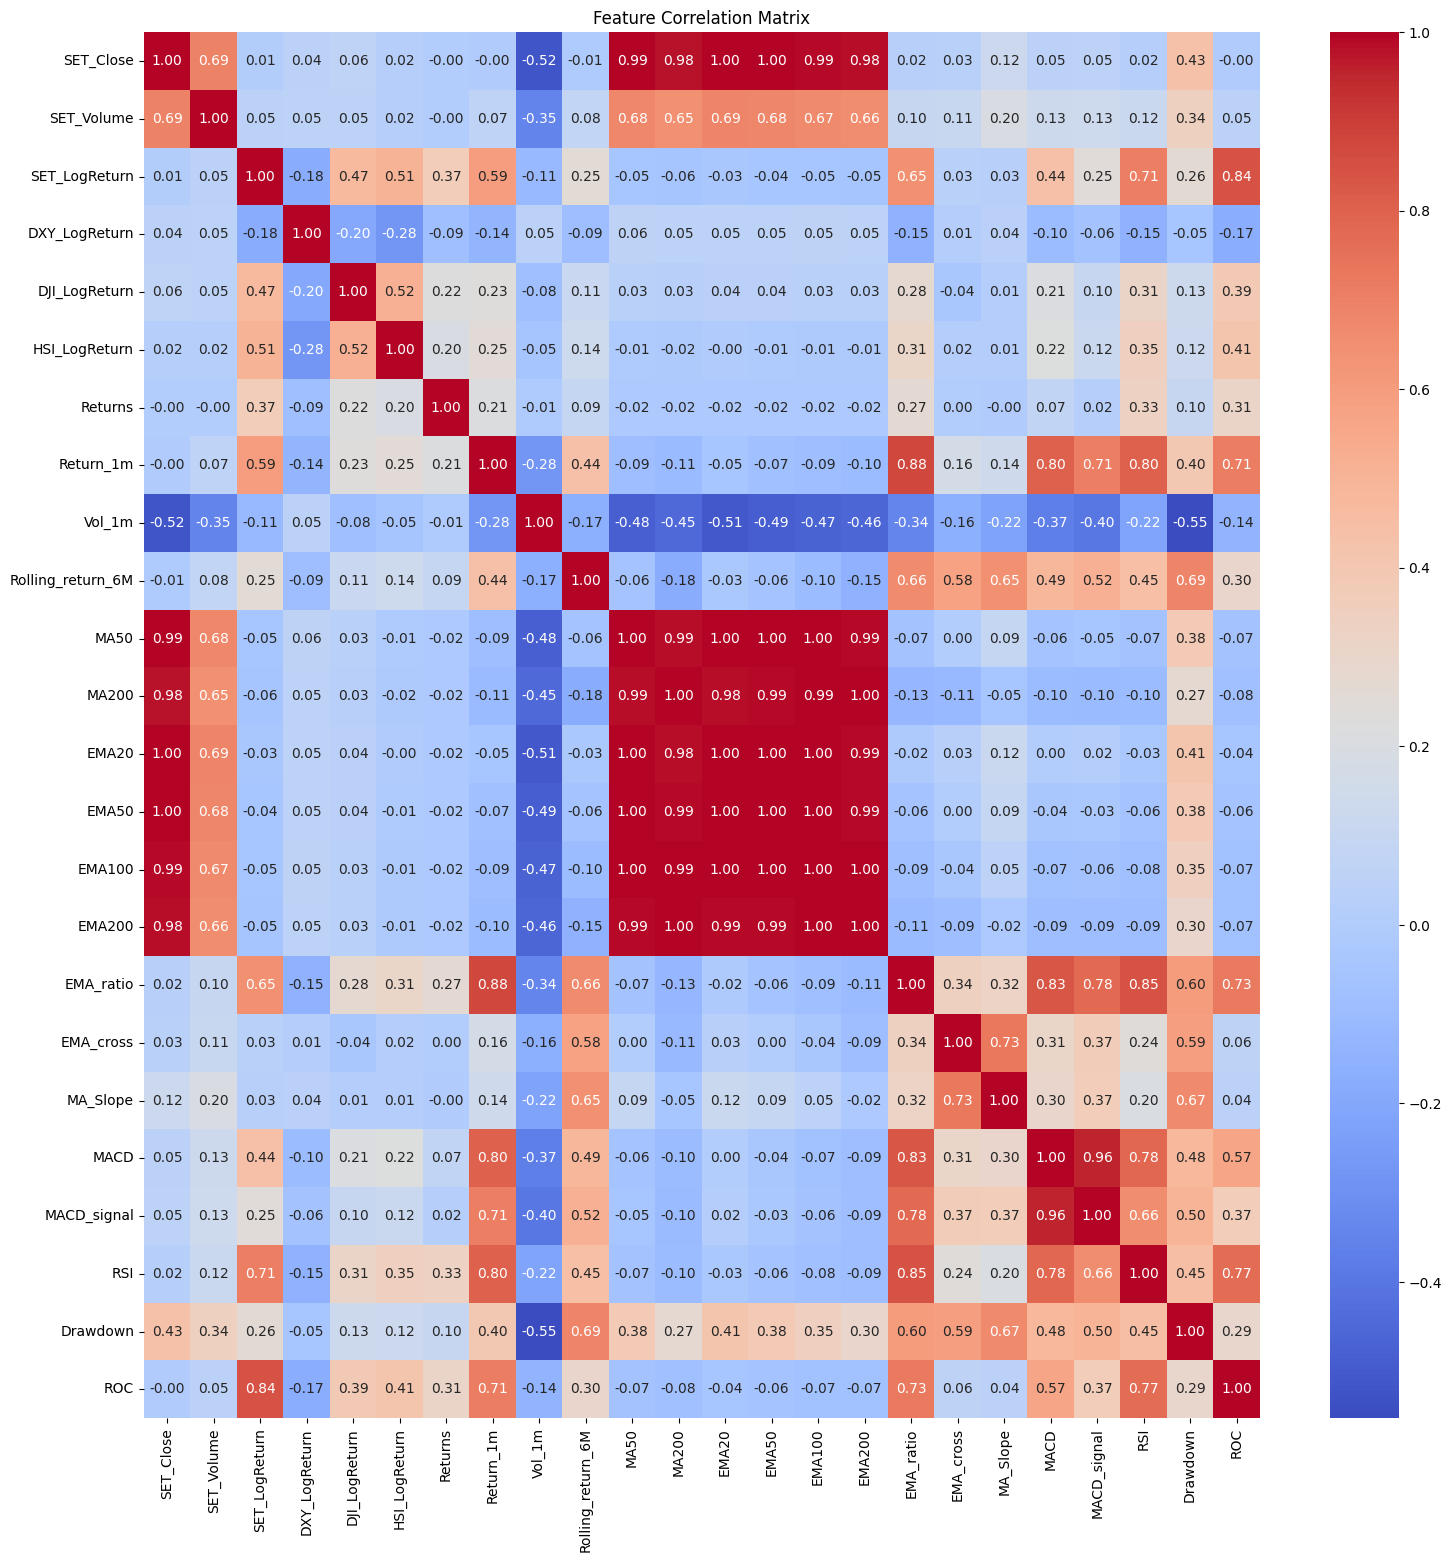

In [16]:
# Create correlation matrix
corr_matrix = price_df.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

In [25]:
# Find index pairs where correlation >= 0.7
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
high_corr = corr_matrix.where(mask)

threshold = 0.7
high_corr_pairs = high_corr.stack().reset_index()
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] >= threshold]

print(high_corr_pairs)

         Feature 1    Feature 2  Correlation
9        SET_Close         MA50     0.994486
10       SET_Close        MA200     0.977610
11       SET_Close        EMA20     0.998507
12       SET_Close        EMA50     0.995942
13       SET_Close       EMA100     0.991725
14       SET_Close       EMA200     0.983984
63   SET_LogReturn          RSI     0.706699
65   SET_LogReturn          ROC     0.843033
148      Return_1m    EMA_ratio     0.875898
151      Return_1m         MACD     0.800076
152      Return_1m  MACD_signal     0.705001
153      Return_1m          RSI     0.804789
155      Return_1m          ROC     0.711083
185           MA50        MA200     0.987653
186           MA50        EMA20     0.998046
187           MA50        EMA50     0.999729
188           MA50       EMA100     0.998407
189           MA50       EMA200     0.992480
198          MA200        EMA20     0.982295
199          MA200        EMA50     0.988221
200          MA200       EMA100     0.994624
201       

### 3 Groups of Features with high correlation (>= 0.7):

Group 1:
SET_Close, MA50, MA200, EMA20, EMA50, EMA100, EMA200

Group 2:
MACD, MACD_signal, EMA_ratio, RSI, Return_1m, SET_LogReturn, ROC

Group 3: 
EMA_cross, MA_Slope

### Feature Selection
As most of the created features are highly correlated, due to the fact that most of them are created from the time-series of SET Index closing prices. Only three features are selected to used as training data: 
- EMA_cross (from Group 3)
- Rolling_return_6M
- Drawdown

For USD Index, DJI Index, and HSI Index, although widely thought to be a driver of SET Index, their movement seem to have significant impact to SET index only in the short run, especially in daily or intraday performance, so we do not select these features for model training. 

In [22]:
print('\n3. Feature selection and prepare data for model training')
selected_features = ['EMA_cross', 'Rolling_return_6M', 'Drawdown']
X_scaled, n_features = prepare_data(price_df, selected_features)

print('Scaled version of X: ')
print(X_scaled)


3. Feature selection and prepare data for model training
Scaled version of X: 
[[ 0.80436061 -0.47288177  0.11628804]
 [ 0.80436061 -0.94313507 -0.45786429]
 [ 0.80436061 -1.18271645 -0.85207726]
 ...
 [-1.24322348 -1.47163406 -1.40364411]
 [-1.24322348 -1.45570143 -1.33781014]
 [-1.24322348 -1.44815062 -1.32250883]]



4. Gaussian Mixture: Train and hyperparameter tuning 

Fitting 1 folds for each of 9 candidates, totalling 9 fits
Best parameters found:  {'covariance_type': 'tied', 'init_params': 'kmeans', 'reg_covar': 1e-06}
Best Silhouette Score: 0.593640


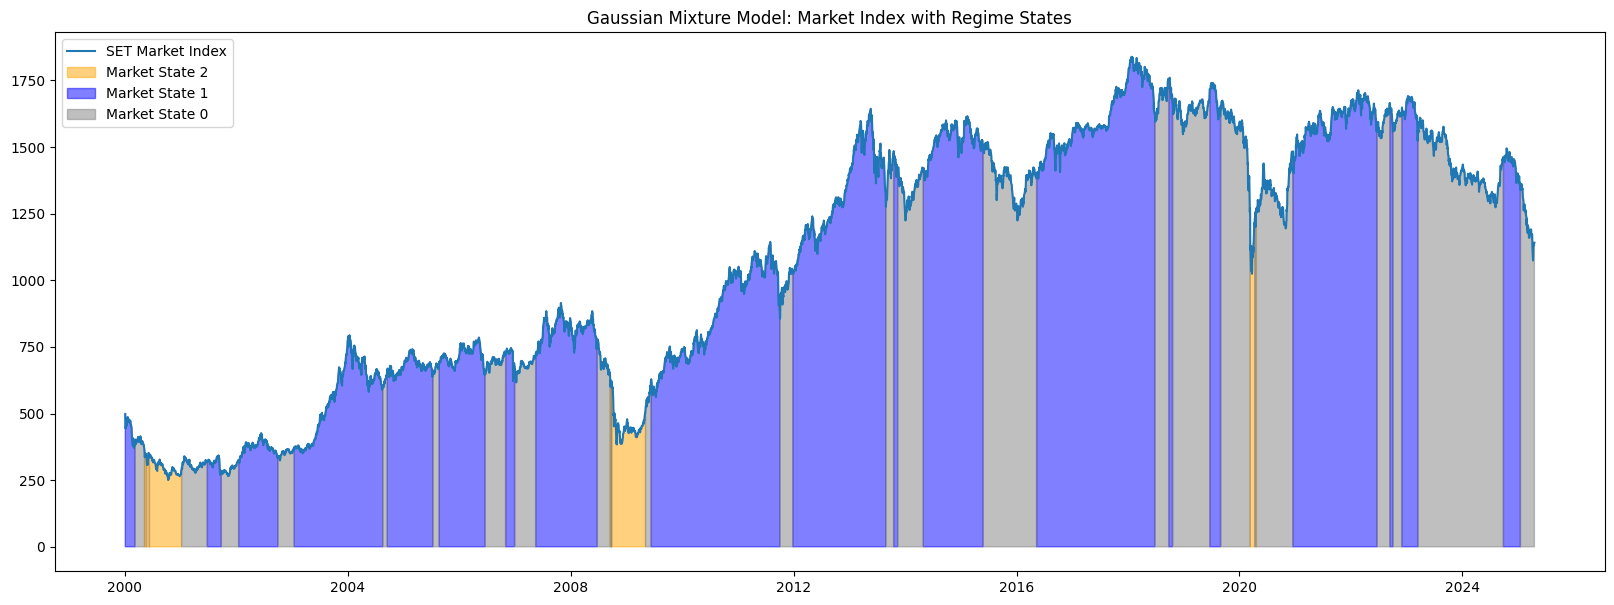

In [11]:
print('\n4. Gaussian Mixture: Train and hyperparameter tuning \n')
gmm_best_model, gmm_y_regime_state, gmm_silhouette_score = GMM_regime_detection(X_scaled, 3)
visualize_clustered_regimes(gmm_y_regime_state, price_df.index, price_df['SET_Close'].values, 'Gaussian Mixture Model', 'GMM_market_regime.png')

### Preliminary analysis on Gaussian Mixture:

The best model has silhouette score of 0.593640, which is quite close to K-Means Clustering and Agglomerative Clustering.
Based on the plot above, 
- Market State 0 (Grey) = Bearish
- Market State 1 (Blue) = Bullish
- Market State 2 (Orange) = Neutral


5. K-Means Clustering: Train and hyperparameter tuning 

Fitting 1 folds for each of 6 candidates, totalling 6 fits
Best parameters found:  {'init': 'random', 'n_init': 10}
Best Silhouette Score: 0.592930


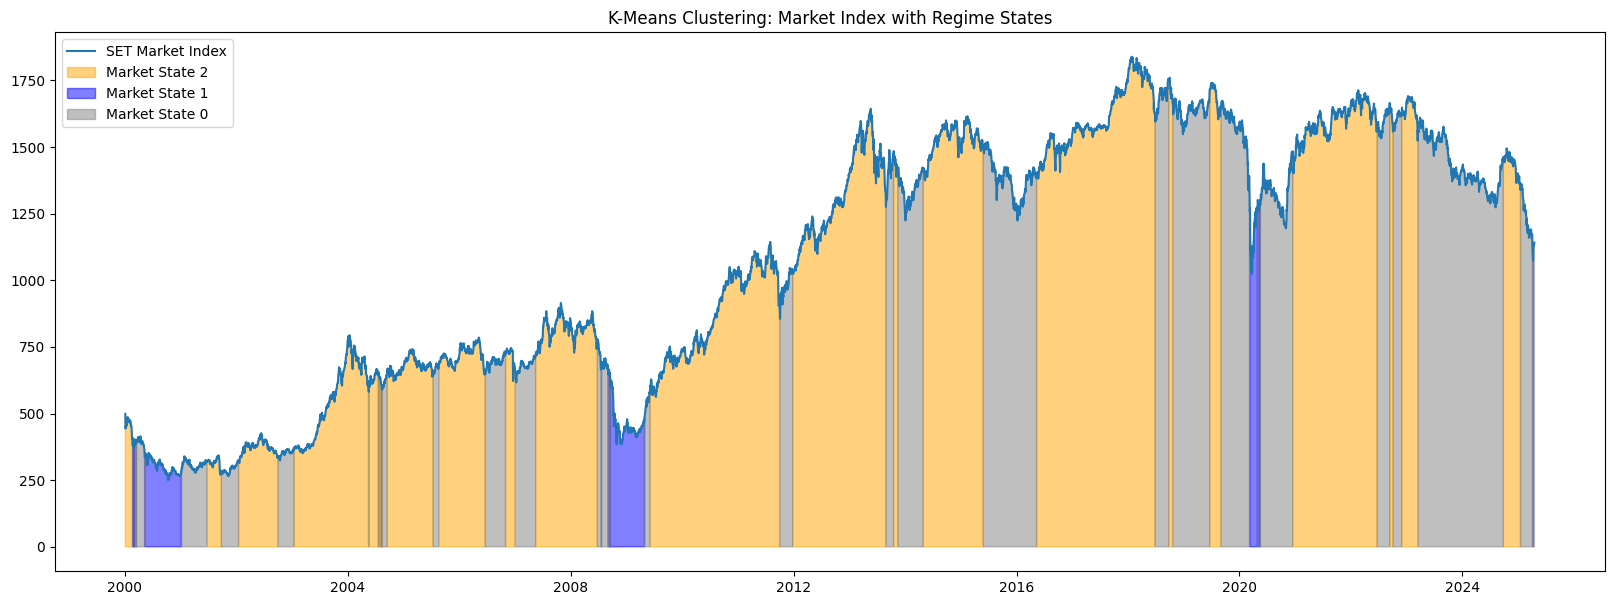

In [12]:
print('\n5. K-Means Clustering: Train and hyperparameter tuning \n')
KMeans_regime_detectionkmeans_best_model, kmeans_y_regime_state, kmeans_silhouette_score = KMeans_regime_detection(X_scaled, 3)
visualize_clustered_regimes(kmeans_y_regime_state, price_df.index, price_df['SET_Close'].values, 'K-Means Clustering', 'KMeans_market_regime.png')

### Preliminary analysis on K-Means Clustering:

The best model has silhouette score of 0.592930, which is quite close to Gaussian Mixture and Agglomerative Clustering.
Based on the plot above, 
- Market State 0 (Grey) = Bearish
- Market State 1 (Blue) = Neutral
- Market State 2 (Orange) = Bullish


6. Agglomerative Clustering: Train and hyperparameter tuning 

Fitting 1 folds for each of 9 candidates, totalling 9 fits
Best parameters found:  {'linkage': 'average', 'metric': 'manhattan'}
Best Silhouette Score: 0.584933


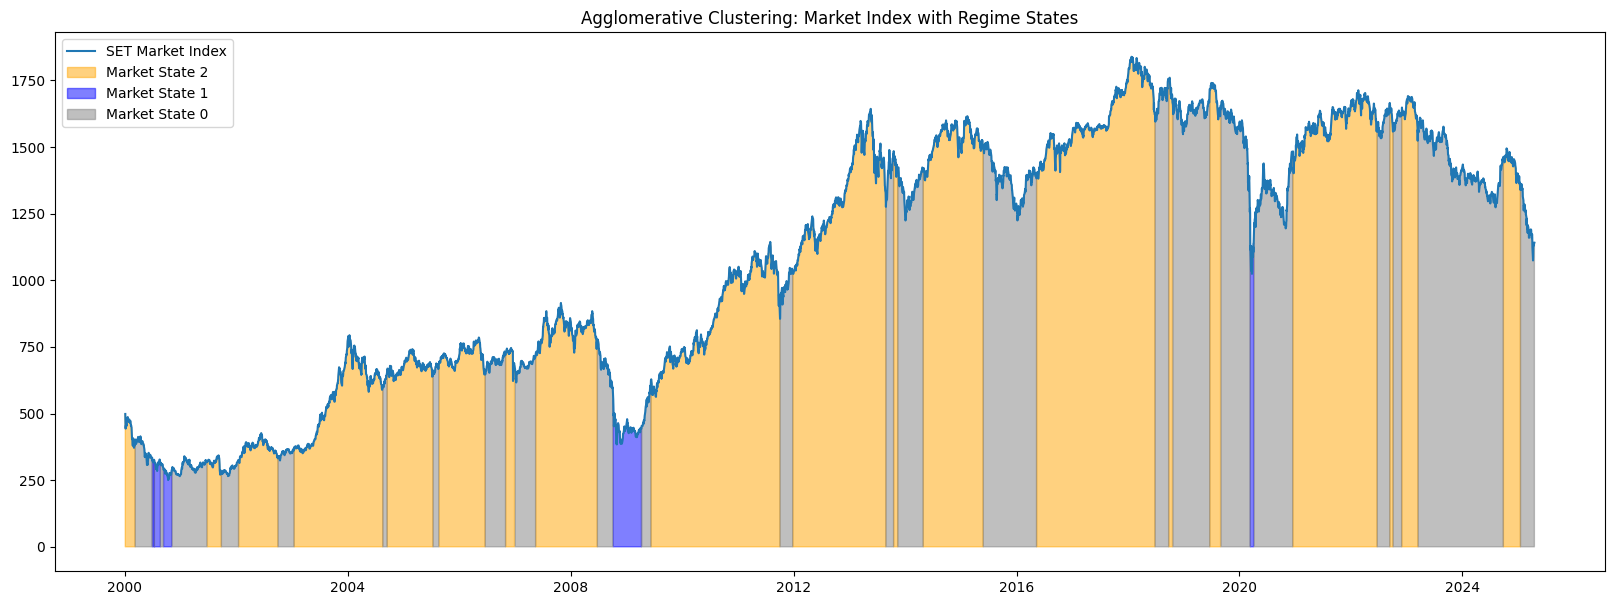

In [13]:
print('\n6. Agglomerative Clustering: Train and hyperparameter tuning \n')
agglo_best_model, agglo_y_regime_state, agglo_silhouette_score = AgglomerativeClustering_regime_detection(X_scaled, 3)
visualize_clustered_regimes(agglo_y_regime_state, price_df.index, price_df['SET_Close'].values, 'Agglomerative Clustering', 'Agglo_market_regime.png')

### Preliminary analysis on Agglomerative Clustering:

The best model has silhouette score of 0.584933, which is quite close to Gaussian Mixture and K-Means Clustering.
Based on the plot above, 
- Market State 0 (Grey) = Bearish
- Market State 1 (Blue) = Neutral
- Market State 2 (Orange) = Bullish


7. LSTM Autoencoder + Gaussian Mixture: Train and hyperparameter tuning 


[1/2] Trying params: {'window_size': 30, 'n_features': 3, 'lstm_units': 64, 'latent_dim': 16, 'batch_size': 32, 'epochs': 30, 'gmm_components': 3, 'init_params': 'kmeans', 'covariance_type': 'full', 'reg_covar': 1e-06}



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 3)          │           195 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,379 (153.82 KB)

 Trainable params: 39,379 (153.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3637
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0800
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0556
Epoch 4/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0455
Epoch 5/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0403
Epoch 6/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0385
Epoch 7/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0347
Epoch 8/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0291
Epoch 9/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0289
Epoch 10/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0257
Epoch 11/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0250
Epoch 12/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0247
Epoch 13/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0230
Epoch 14/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0208
Epoch 15/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 3)          │           195 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,379 (153.82 KB)

 Trainable params: 39,379 (153.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3504
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0855
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0566
Epoch 4/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0449
Epoch 5/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0369
Epoch 6/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0311
Epoch 7/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0296
Epoch 8/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0292
Epoch 9/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0259
Epoch 10/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0255
Epoch 11/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0262
Epoch 12/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0231
Epoch 13/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0247
Epoch 14/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0229
Epoch 15/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s

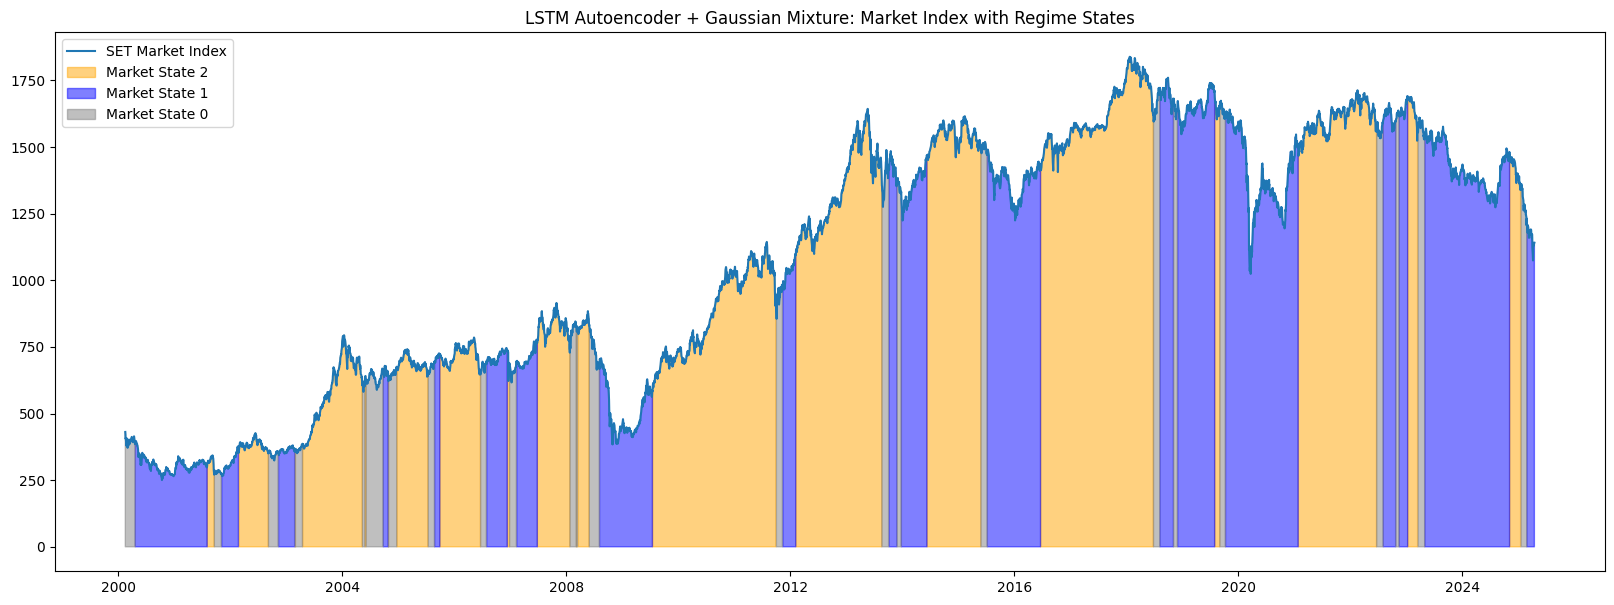

In [14]:
print('\n7. LSTM Autoencoder + Gaussian Mixture: Train and hyperparameter tuning \n')
autoencoder_best_model, autoencoder_y_regime_state, autoencoder_silhouette_score = LSTMAutoencoder_GMM_regime_detection(X_scaled, 3, n_features)
visualize_clustered_regimes(autoencoder_y_regime_state, price_df.index[autoencoder_best_model.window_size:], price_df['SET_Close'].values[autoencoder_best_model.window_size:], 'LSTM Autoencoder + Gaussian Mixture', 'Autoencoder_market_regime.png')

### Preliminary analysis on LSTM Autoencoder + Gaussian Mixture:

Initially, it was expected that with LSTM Autoencoder, noise in the time series will be removed and that should help improve silhouette score.<br>
However, the best model has silhouette score of 0.2099, which is much lower than non-deep learning models. <br>
Based on the plot above, <br>
- Market State 0 (Grey) = Neutral
- Market State 1 (Blue) = Bearish
- Market State 2 (Orange) = Bullish

### Evaluation and Summary

Silhouette score is used as our evaluation metrics, as it relies only on cluster assignments and distance between samples, without true labels. <br>
In all model trainings above, hyperparameter tuning is done in order to get the highest Silhouette score. <br>

However, good clustering in the case of stock market regime detection should mean adjacent time steps stay in the same cluster/regime (implying that regime should be smooth, without changing frequently). Silhouette score may not directly measure how predicted regime time series is smooth or not.<br>

According to some research papers, it seems that there is no standard score for stock market regime detection, and, in general, any clustering of time-series data with temporal coherence. Some researchers proposed their own measurement scores but they are not widely used.<br>

Based on Silhouette score, the performance of models are:<br>

Gaussian Mixture (0.593640) > K-Means Clustering (0.592930) > Agglomerative Clustering (0.584933) > LSTM Autoencoder + Gaussian Mixture (0.2099)<br>

Although Gaussian Mixture achieve highest score, but difference between Gaussian Mixture and other two non-deep learning models are insignificant. <br>
LSTM Autoencoder + Gaussian Mixture, as the only deep learning model, was initially expected that noise in the time series will be removed and thus helped improve silhouette score. <br>
However, the result does not align with this expectation at all, as its resulting score is the lowest.<br>

For clustering with LSTM Autoencoder + Gaussian Mixture, even though silhouette score is low, but overall, the predicted regime quite aligns with expectation of typical investment professionals. <br>

### Possible Enhancement
Improvement can be made by incorporating other features or technical indicators into the model. The author has researched on possible data from the World Bank API, however, most of them are available on yearly basis, and the World Bank does not provide the actual release date of these data. The release date is key because it can trigger price action at the date of the public release. There are monthly/quarterly economic data available on a few online data sources, but they are not freely available and require subscription.<br>

Most technical indicators themselves can be configured by setting different rolling period. For LSTM Autoencoder, Gaussian Mixture may be replaced with other clustering algorithms.<br>